# Simple Neural Network
## Day 1 - Solving XOR

In this section, the basic of the neural network will be reviewed. This basics includes the implementation of the forward and backward path of a neural network and try to solve XOR problem. The reason XOR is chosen is that, it is not linear and thus can not be solved linear discriminators as well as one simple perceptron. We firts solve the XOR problem and then, after the network proofed, we jump to harder problems.

Below is the implementation of this function for two inputs as well as all four possible combination of the inputs.

In [1]:
import os
import numpy as np
from random import randint
import matplotlib.pyplot as plt

def xor(x, y):
    return 1 if x+y != 1 else 0

x_train = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1],
])

y_train = np.array([xor(i[0], i[1]) for i in x_train])

for i in range(4):
    print x_train[i], '~>', y_train[i]

[0 0] ~> 1
[0 1] ~> 0
[1 0] ~> 0
[1 1] ~> 1


Next, let's define an activation function. This will add the non-linearity to the neuron model. The function we want use is `sigmoid` function. Sigmoid is one of the most popular activations in the Neural Networks. It is defined as below:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

This means, whenever the input is low (let's say below -4) the activation function returns 0 and on the other hand, when the input is high (similar to the previous, like +4 and above) the activation function return active or 1. This function is plotted in the below section.

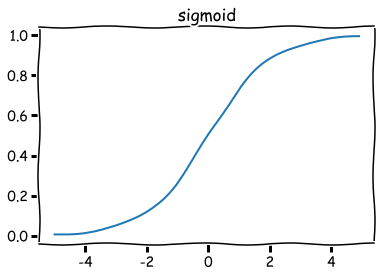

In [2]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

with plt.xkcd():
    x = np.array(list(range(-50, +50))) / 10.0
    plt.plot(x, sigmoid(x))
    plt.title('sigmoid')
    plt.show()

To solve this problem we have used a two-layered structure as depicted below. We know this structure is capable of solving this problem. We can test it by set the weights manually. Note that in this structure the a1 plays role of AND function and a2 playes the role of AND-of-Negative-Inputs. and then o has functionality of OR function and has the output we desire.
![Neural Networkk Design](nn_design.png)

In [3]:
W1 = np.array([[20, 20], [-20, -20]])
B1 = np.array([[-30], [10]])

W2 = np.array([[20, 20]])
B2 = np.array([[-10]])

The calculation of each layer of the network is as below. In which the weight of each connection is multiplied by the value of the connection end. Then these values sum up together to form the observation of the neuron, $z$. Then the non-linearity function, also known as activation function, is applied. This calculation for the layer $L$ of the network is drived as:

$$
z_l = w^l z_{l-1} + b^l \\
a_l = g(z_l)
$$

In this equations, the g is the activation function. The W is the weight matrix, and consists of the weight of the whole layer L. We have to note that, $ z_0 $ is the input values or $x^{(i)}$. Below is the implementation of these equation:

In [4]:
x0 = np.reshape(x_train[0], (2, 1))

# Layer #1
z1 = W1.dot(x0) + B1
a1 = sigmoid(z1)

# Layer #2
z2 = W2.dot(a1) + B2
a2 = sigmoid(z2)

output = 1 if z2 > 0.5 else 0
print x_train[0], '~~>', output

[0 0] ~~> 1


If we tie together these operations, we would have `forward` function. Then we can run it for the entier train set:

In [5]:
def forward(a0):
    # Layer #1
    z1 = W1.dot(a0) + B1
    a1 = sigmoid(z1)

    # L\ayer #2
    z2 = W2.dot(a1) + B2
    a2 = sigmoid(z2)
    return a2

for x_i, y_i in zip(x_train, y_train):
    print x_i, '~~>', '%.2f' % forward(np.reshape(x_i, (2,1))), '[%d]' % y_i

[0 0] ~~> 1.00 [1]
[0 1] ~~> 0.00 [0]
[1 0] ~~> 0.00 [0]
[1 1] ~~> 1.00 [1]


## Backpropagation

Up to here, we have imagined we have the weights for the network. But how one should come up with these weights? In this section we will walk through the process of calculating these weights. First, let's say we have random weights. Then, we need a way to tell how well these random weight will perform on the input set. Thus, we define a loss function as:

$$
J(W) = \frac{1}{m} \sum_{i=1}^{m}{(\hat{Y}^{(i)} - y^{(i)}) ^ 2}
$$

In [6]:
# randomly initialize the weights
W1 = np.random.uniform(low=0, high=+1, size=(2,2))
B1 = np.random.uniform(low=0, high=+1, size=(2,1))
W2 = np.random.uniform(low=0, high=+1, size=(1,2))
B2 = np.random.uniform(low=0, high=+1, size=(1,1))

In [7]:
# calculating loss function - logistic error
loss = 0
for x_i, y_i in zip(x_train, y_train):
    h_t = forward(np.reshape(x_i, (2,1)))    
    loss += (h_t - y_i) ** 2
loss /= x_train.shape[0]

print 'loss = %.2f' % loss

loss = 0.37


Before the next step, we have to augment the inputs in order to achieve a better performance (Since, the oprations are in form of matrix multiplication, it's faster to do it over augmented results rather than run it several times).

In [8]:
x_train_aug = []
y_train_aug = []
for _ in range(1024):
    a = randint(0, 1)
    b = randint(0, 1)
    x_train_aug.append([a, b])
    y_train_aug.append([xor(a, b)])

x_train_aug = np.array(x_train_aug)
y_train_aug = np.array(y_train_aug)

In order to computer the weights, we have to optimize them gradually toward the optimal state, by minimizing the `loss` value. To do so, we simply have to calculate the derivation of the `loss` value with respect of each weight and then subtract a portion of it from that weight on each iteration. These derivations are calculated as below:

$$
\frac{\partial J}{\partial W_j} = \frac{1}{m} \sum_{i=1}^{m}{ \frac{ \partial J^{(i)} }{\partial y^{(i)}} \frac{\partial y^{(i)}}{\partial w_j} }
$$

So we have:

$$
 = \frac{1}{m} \sum_{i=1}^{m}{ \frac{ \partial (\hat{y}^{(i)} - y^{(i)})^2 }{\partial y^{(i)}} \frac{\partial y^{(i)}}{\partial w_j} }
$$

And after calculating the derivation we would have:

$$
\nabla_wL = -\sum_{i=1}^{m}{ (\hat{y}^{(i)} - y^{(i)}) \frac{\partial y^{(i)}}{\partial w_j} }
$$

Finally, with having the gradient we can update the weights:

$$
W^{t+1} = W^t + \eta \nabla_wL
$$

In which the $\eta$ is a hyperparameter of the system and is called learning-rate.

In [9]:
def derivative_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x)) 

In [10]:
# first run the forward path in other to have the output layers
x_t = x_train[0]
y_t = y_train[0]

a0 = np.reshape(x_t, (2,1))

# Layer #1
z1 = W1.dot(a0) + B1
a1 = sigmoid(z1)

# Layer #2
z2 = W2.dot(a1) + B2
a2 = sigmoid(z2)

In [11]:
y_hat = a2

e2 = y_t - y_hat
delta_2 = e2 * derivative_sigmoid(z2)
print '𝛿2:', delta_2

delta_1 = W2.T.dot(delta_2) * derivative_sigmoid(z1)
print '𝛿1:', delta_1

𝛿2: [[0.02599883]]
𝛿1: [[0.00637424]
 [0.00175163]]


So, we calculate the $\Delta$ value for each weight as below:

In [12]:
# now do the above for all trainset
def backward(x0, y0):
    # Forward
    z1 = W1.dot(x0) + B1
    a1 = sigmoid(z1)
    z2 = W2.dot(a1) + B2
    a2 = sigmoid(z2)
    
    # Backward
    delta_2 = (y0-a2)*(derivative_sigmoid(z2))
    delta_1 = W2.T.dot(delta_2)*(derivative_sigmoid(z1))

    m = x0.shape[1]

    d1w = delta_1.dot(x0.T) / float(m)
    d1b = delta_1.dot(np.ones((m,1))) / float(m)
    
    d2w = delta_2.dot(a1.T) / float(m)
    d2b = delta_2.dot(np.ones((m,1))) / float(m)
    return d1w, d1b, d2w, d2b 


Delta_1_w = np.zeros_like(W1)
Delta_1_b = np.zeros_like(B1)
Delta_2_w = np.zeros_like(W2)
Delta_2_b = np.zeros_like(B2)

for x_t, y_t in zip(x_train, y_train):
    d1w, d1b, d2w, d2b = backward(np.reshape(x_t, (2,1)), y_t)
    Delta_1_w += d1w
    Delta_1_b += d1b
    Delta_2_w += d2w
    Delta_2_b += d2b
    
print 'Δ1w:\n', Delta_1_w
print 'Δ1b:\n', Delta_1_b
print ''
print 'Δ2w:\n', Delta_2_w
print 'Δ2b:\n', Delta_2_b

Δ1w:
[[-0.02435853 -0.01896964]
 [-0.00614098 -0.00507039]]
Δ1b:
[[-0.04008598]
 [-0.01027731]]

Δ2w:
[[-0.11830779 -0.14295591]]
Δ2b:
[[-0.18080588]]


Finally, we run the eintire process in a loop for `epoch` iterations:

In [13]:
W1 = np.random.uniform(low=0, high=+1, size=(2,2))
B1 = np.random.uniform(low=0, high=+1, size=(2,1))
W2 = np.random.uniform(low=0, high=+1, size=(1,2))
B2 = np.random.uniform(low=0, high=+1, size=(1,1))

# used in plotting the progress
loss_history = []
hist_W1 = []
hist_B1 = []
hist_W2 = []
hist_B2 = []

In [14]:
epochs = 30000
batch_size = 64
lr = .02

for e in range(epochs): 
    i=0
    batch_loss = []
    while(i<x_train_aug.shape[0]):
        x_batch = x_train_aug.T[:, i:i+batch_size]
        y_batch = y_train_aug.T[:, i:i+batch_size]
        i += batch_size

        d1w, d1b, d2w, d2b = backward(x_batch, y_batch)

        W1 += lr * d1w
        B1 += lr * d1b

        W2 += lr * d2w
        B2 += lr * d2b

        a2 = forward(x_batch)
        batch_loss.append(np.linalg.norm(a2 - y_batch))

    loss_history.append(np.mean(batch_loss))
    hist_W1.append(W1.flatten())
    hist_B1.append(B1.flatten())
    hist_W2.append(W2.flatten())
    hist_B2.append(B2.flatten())

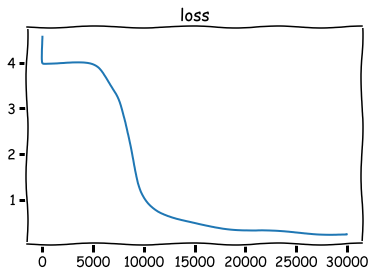

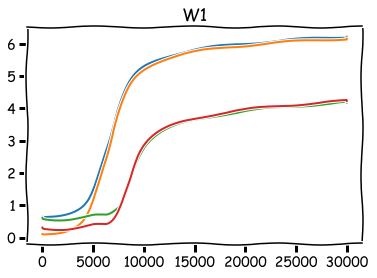

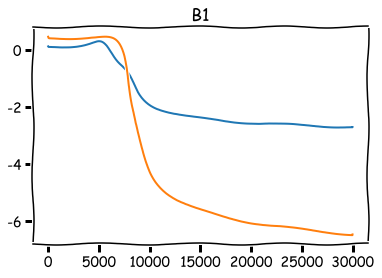

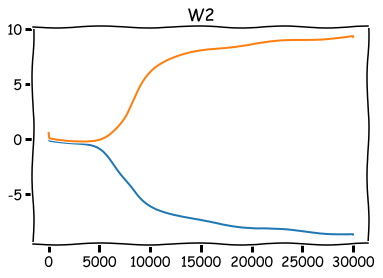

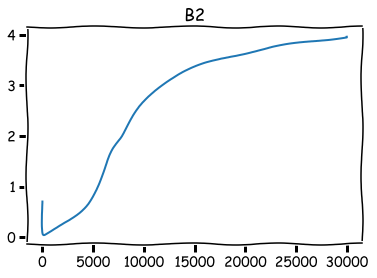

In [15]:
with plt.xkcd():
    plt.plot(loss_history)
    plt.title('loss')
    plt.show()

    plt.plot(hist_W1)
    plt.title('W1')
    plt.show()

    plt.plot(hist_B1)
    plt.title('B1')
    plt.show()

    plt.plot(hist_W2)
    plt.title('W2')
    plt.show()

    plt.plot(hist_B2)
    plt.title('B2')
    plt.show()

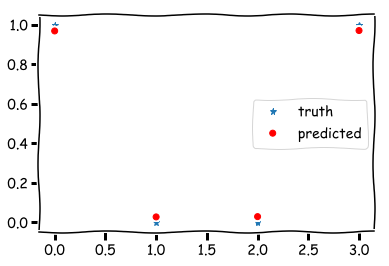

[0 0] ~~> 1 (=0.97) [1]
[0 1] ~~> 0 (=0.03) [0]
[1 0] ~~> 0 (=0.03) [0]
[1 1] ~~> 1 (=0.97) [1]


In [16]:
M = x_train_aug.shape[0]
xx = x_train_aug[:, 0] + x_train_aug[:, 1] * 2
xx = np.reshape(xx, (M, 1)).transpose()

y_hat = forward(x_train_aug.T)

with plt.xkcd():
    plt.plot(xx.T, y_train_aug, '*', label='truth')
    plt.plot(xx.T, y_hat.T, 'ro', label='predicted')
    plt.legend()
    plt.show()

for x_i, y_i in zip(x_train, y_train):
    a = forward(np.reshape(x_i, (2, 1)))
    r = 1 * (a > 0.5)
    print x_i, '~~>', '%d (=%.2f)' % (r, a), '[%d]' % y_i

--------------------------------------

In the next section we will optimize this code to have more felixible neural network and try to run it on more advanced datasets. Please follow up with this [link](https://github.com/ArefMq/simple-nn/blob/master/Day-2.ipynb).